In [1]:
#Load libraries
import numpy as np
import math 
import matplotlib.pyplot as plt 
import time
from sklearn.svm import OneClassSVM
%matplotlib inline

#Load dataset
data = np.genfromtxt('art_daily_small_noise.csv', delimiter=',')

Text(0, 0.5, 'Value')

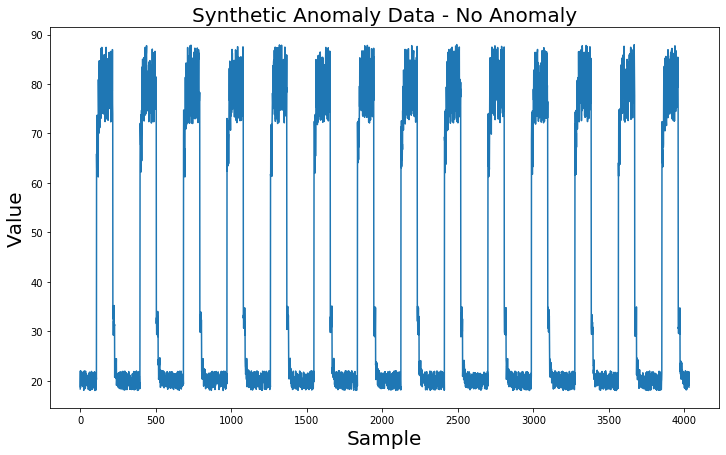

In [2]:
plt.figure(figsize=(12,7))
plt.plot(range(len(data)),data)
plt.title("Synthetic Anomaly Data - No Anomaly",fontsize=20)
plt.xlabel("Sample",fontsize=20)
plt.ylabel("Value",fontsize=20)

# Power Martingale

In [3]:
SVM=OneClassSVM()
#Reshape data for one class svm
data_re=data.reshape(-1,1)
#Initialize variable for storage
p_values=np.append(1,np.zeros(len(data_re)-1))
bet=np.append(1,np.zeros(len(data_re)-1))
online_X_train=data_re[0]

epsilon=0.92 
N=len(data_re)
C=10**4 #Threshold value
i=0
sigma=[0] #List of indices of detected anomalies
M=[1] #Initialize martingale value


for n in range(1,N):
    #Take sequence of data samples from last anomaly detected to n
    seq=data_re[sigma[i]+1:n+1]
    if len(seq)==1: #p-value for a sequence of length one is equal to one
        score=1
        p_values[n]=score
    else:
        #Calculate p-value for test sample based on sequence
        SVM.fit(seq)
        d_func=SVM.decision_function(seq)
        score=-1*d_func
        p_values[n]=np.mean(score>=score[-1])

    #Calculate output of betting function for p-value    
    bet[n]=epsilon * (p_values[n] ** (epsilon - 1))
    #Martingale is the product of all previous betting functions from last anomaly detected to n
    Mn=np.prod(bet[sigma[i]+1:n+1])
    M=np.append(M,Mn)
    
    #If the martingale value reaches the threshold record its indices
    if Mn>C:
        i=i+1
        sigma=np.append(sigma,n)

Text(0.5, 1.0, ' Power Martingales - No Anomaly Dataset')

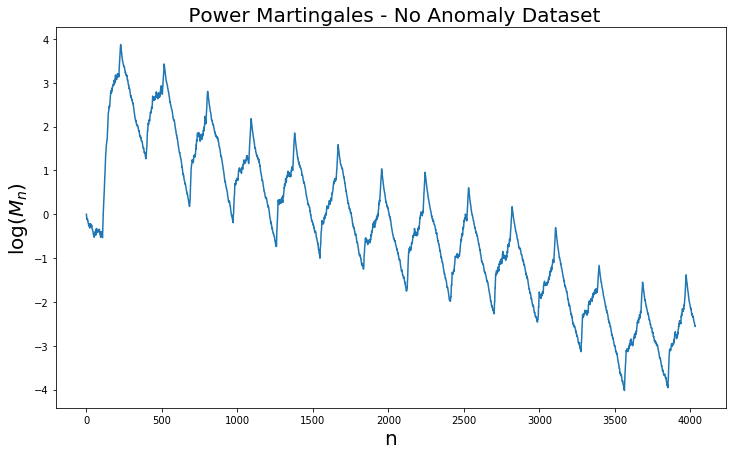

In [4]:
plt.figure(figsize=(12,7))
plt.plot(range(len(M)),np.log10(M))
plt.xlabel("n",fontsize=20)
plt.ylabel("log($M_n$)",fontsize=20)
plt.title(" Power Martingales - No Anomaly Dataset",fontsize=20)

In [5]:
len(sigma[1:])

0

In [6]:
threshold=[10**0.5,10**1,10**2,10**3,10**4,10**5,10**6,10**7]
#False alarm rates found at different thresholds
false_alarm_rate_martin=[(28/len(M))*100,(28/len(M))*100,(9/len(M))*100,(1/len(M))*100,0,0,0,0]

# MUSUC

In [7]:
SVM=OneClassSVM()
#Reshape data for one class svm
data_re=data.reshape(-1,1)
online_X_train=data_re[0]

N=len(data_re)
C=10**6 #Threshold value
i=0
sigma=[0] #List of indices of detected anomalies

#Initialize variables to store MUSUC outputs
E_n=np.zeros(len(data_re))
E_score=[]

for n in range(1,N):
    #Take sequence of data samples from last anomaly detected to n
    seq=data_re[sigma[i]+1:n+1]
    if len(seq)==1: #E_n for a sequence of length one is equal to one
        score=1
        E_n[n]=score
    else:
        #Calculate E-value for test sample based on sequence
        SVM.fit(seq)
        d_func=SVM.decision_function(seq)
        score=-1*d_func
        if np.std(score)==0:
            E_val=(score-(np.mean(score)))  +1
        else:
            E_val=0.1*((score-(np.mean(score)))/np.std(score))  +1
        E_n[n]=E_val[-1]
    
    #MUSUC output is the product of all previous E-values from last anomaly detected to n
    E_prod=np.prod(E_n[sigma[i]+1:n+1])

    E_score=np.append(E_score,E_prod)
    
    #If the MUSUC value reaches the threshold record its indices
    if E_prod>C:
        i=i+1
        sigma=np.append(sigma,n)


Text(0.5, 1.0, ' MUSUC - No Anomaly Dataset')

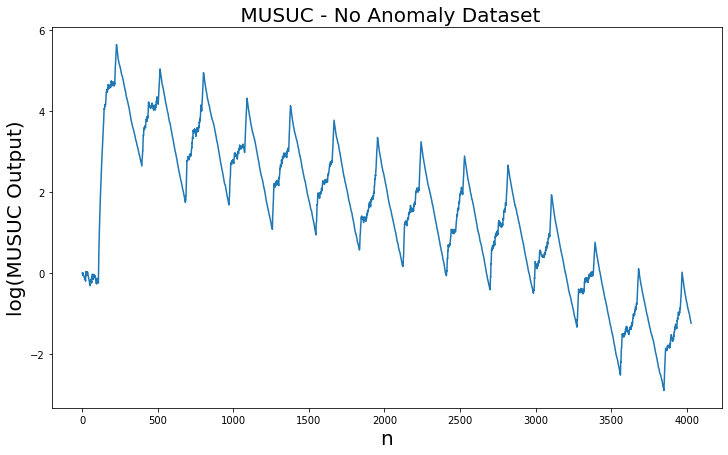

In [8]:
plt.figure(figsize=(12,7))
plt.plot(range(len(E_score)),np.log10(E_score))
plt.xlabel("n",fontsize=20)
plt.ylabel("log(MUSUC Output)",fontsize=20)
plt.title(" MUSUC - No Anomaly Dataset",fontsize=20)

In [9]:
len(sigma[1:])

0

In [10]:
#False alarm rates found at different thresholds
false_alarm_rate_MUSUC=[(30/len(M))*100,(28/len(M))*100,(28/len(M))*100,(26/len(M))*100,(3/len(M))*100,(1/len(M))*100,0,0]

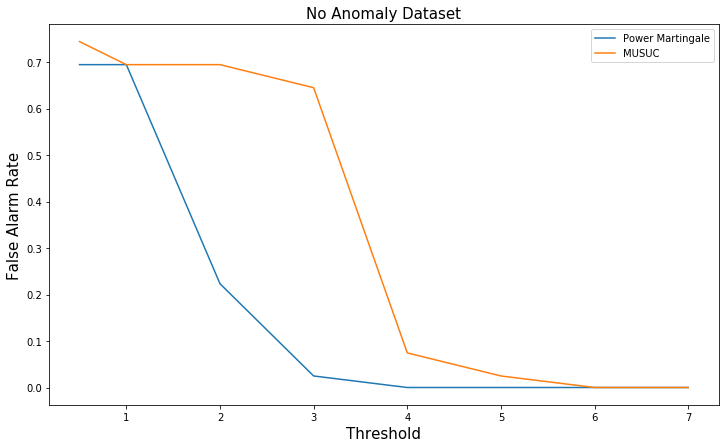

In [11]:
plt.figure(figsize=(12,7))
plt.plot(np.log10(threshold),false_alarm_rate_martin)
plt.plot(np.log10(threshold),false_alarm_rate_MUSUC)
plt.title("No Anomaly Dataset",fontsize=15)
plt.xlabel("Threshold",fontsize=15)
plt.ylabel("False Alarm Rate",fontsize=15)
plt.legend(["Power Martingale","MUSUC"])